In [48]:
import h5py
import numpy as np
import multiprocessing as mp
from utils import calculate_gmrotd50
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as transforms
import os
from einops import rearrange
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from multiprocessing import shared_memory
from example_GMM import calculate_gmfs, calculate_gmfs_distance
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})


In [ ]:
class SeismicParameters:
    """
    Class for reading and accessing seismic parameters from H5 files
    using dot notation (params.hypocentral_distance, params.magnitude, etc.)
    """
    
    def __init__(self, file_path=None):
        """
        Initialize SeismicParameters object.
        
        Parameters:
        -----------
        file_path : str, optional
            Path to the H5 file. If provided, automatically loads data.
        """
        # Initialize basic attributes
        self._file_path = None
        
        # Load data if file path is provided
        if file_path:
            self.load_file(file_path)
    
    def load_file(self, file_path):
        """
        Load parameters from an H5 file.
        
        Parameters:
        -----------
        file_path : str
            Path to the H5 file
            
        Returns:
        --------
        self
            For method chaining
        """
        self._file_path = file_path
        
        # Open the H5 file with locking=False
        with h5py.File(file_path, 'r', locking=False) as file:
            # Map specific parameter names to more intuitive attributes
            parameter_mapping = {
                'hypocentral_distance': 'hypocentral_distance',
                'magnitude': 'magnitude',
                'vs30': 'vs30s',
                'hypocentre_depth': 'hypocentre_depth',
                'azimuthal_gap': 'azimuthal_gap'
            }
            
            # Add mapped parameters as attributes
            for h5_name, attr_name in parameter_mapping.items():
                if h5_name in file:
                    setattr(self, attr_name, file[h5_name][:])
            
            # Add any other parameters as attributes with original names
            for key in file.keys():
                if key not in parameter_mapping:
                    setattr(self, key, file[key][:])
        
        return self
    
    def get_data_info(self):
        """
        Returns information about the loaded data.
        
        Returns:
        --------
        dict
            Dictionary with information about available parameters and their shapes
        """
        info = {
            'file_path': self._file_path,
            'parameters': {}
        }
        
        # Get attributes that are numpy arrays (parameters)
        for attr in dir(self):
            if not attr.startswith('_') and not callable(getattr(self, attr)):
                value = getattr(self, attr)
                if isinstance(value, np.ndarray):
                    info['parameters'][attr] = {
                        'shape': value.shape,
                        'dtype': str(value.dtype),
                        'min': float(np.min(value)) if value.size > 0 else None,
                        'max': float(np.max(value)) if value.size > 0 else None
                    }
        
        return info
    
    def __repr__(self):
        """String representation of the SeismicParameters object"""
        if self._file_path:
            return f"SeismicParameters(file='{self._file_path.split('/')[-1]}')"
        else:
            return "SeismicParameters(file=None)"

def process_waveform(index, EW, NS):
    gmrot50 = calculate_gmrotd50(EW, NS)
    return index, gmrot50

def parallel_process_waveforms(waveforms_EW, waveforms_NS, n_workers=4):
    with mp.Pool(n_workers) as pool:
        results = list(tqdm(pool.starmap(process_waveform, [(i, waveforms_EW[i, :], waveforms_NS[i, :]) for i in range(len(waveforms_EW[:, 0]))]), total=len(waveforms_EW[:, 0])))
    return sorted(results, key=lambda x: x[0])

def integrate_frequency_domain(signal, dt):
    N = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, dt)

     # Create highpass filter mask (frequencies above 0.1 Hz)
    highpass_mask = np.abs(freqs) >= 0.1
    
    # Apply highpass filter
    fft_signal = fft_signal * highpass_mask
    
    # Integrate by dividing by j*omega
    fft_signal[1:] = fft_signal[1:] / (1j * 2 * np.pi * freqs[1:])
    fft_signal[0] = 0  # handle the DC component separately
    
    integrated_signal = np.fft.ifft(fft_signal).real
    return integrated_signal

def filter_frequency_domain(signal, dt):
    N = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, dt)

     # Create highpass filter mask (frequencies above 0.1 Hz)
    highpass_mask = np.abs(freqs) >= 0.1
    
    # Apply highpass filter
    fft_signal = fft_signal * highpass_mask
    
    filtered_signal = np.fft.ifft(fft_signal).real
    return filtered_signal

def evaluate_ratio(target, predicted, dt=0.01, n_worker=4, evaluate_obs=True, PGV=True):
    """
    Evaluate the ratio between target and predicted waveforms.
    
    Parameters:
    -----------
    target : numpy.ndarray
        Target waveforms with shape (n_samples, 2, time_steps)
    predicted : numpy.ndarray
        Predicted waveforms with shape (n_samples, 2, time_steps)
    dt : float
        Time step for integration
    n_worker : int, optional
        Number of workers for parallel processing (default: 4)
    evaluate_obs : bool, optional
        Whether to evaluate observations (default: True)
        
    Returns:
    --------
    dict or numpy.ndarray
        If evaluate_obs=True, returns a dictionary with PGV values for both observations and predictions
        Otherwise, returns only the predictions PGV values
    """
    # Load waveforms in chunks
    chunk_size = 1000  # adjust based on memory constraints
    num_chunks = int(np.ceil(target.shape[0] / chunk_size))

    results_obs = []
    results_gm0 = []

    if PGV: 
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, target.shape[0])
            
            waveforms_chunk = target[start_idx:end_idx]
            tqdne_chunk = predicted[start_idx:end_idx]
            
            wf_NS = waveforms_chunk[:, 0, :]
            wf_EW = waveforms_chunk[:, 1, :]
            st_tqdne_EW = tqdne_chunk[:, 1, :]
            st_tqdne_NS = tqdne_chunk[:, 0, :]

            print("Integrate waveforms in the frequency domain")
            integrated_st_tqdne_EW = np.array([integrate_frequency_domain(wf, dt) for wf in st_tqdne_EW])
            integrated_st_tqdne_NS = np.array([integrate_frequency_domain(wf, dt) for wf in st_tqdne_NS])
            
            if evaluate_obs:
                integrated_wf_EW = np.array([integrate_frequency_domain(wf, dt) for wf in wf_EW])
                integrated_wf_NS = np.array([integrate_frequency_domain(wf, dt) for wf in wf_NS])
            
                print("Processing observation...")
                chunk_results_obs = parallel_process_waveforms(integrated_wf_EW, integrated_wf_NS, n_workers=n_worker)
                results_obs.extend(chunk_results_obs)
            
            print("Processing GM0...")
            chunk_results_gm0 = parallel_process_waveforms(integrated_st_tqdne_EW, integrated_st_tqdne_NS, n_workers=n_worker)
            results_gm0.extend(chunk_results_gm0)

        # Extract PGV geometric mean values
        PGV_geom_mean_gm0 = np.array([result[1] for result in results_gm0])
        
        if evaluate_obs:
            PGV_geom_mean_obs = np.array([result[1] for result in results_obs])
            results = {
                "PGV_geom_mean_obs": PGV_geom_mean_obs,
                "PGV_geom_mean_gwm": PGV_geom_mean_gm0
            }
        else:
            results = PGV_geom_mean_gm0
    else:
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, target.shape[0])
            
            waveforms_chunk = target[start_idx:end_idx]
            tqdne_chunk = predicted[start_idx:end_idx]
            
            wf_NS = waveforms_chunk[:, 0, :]
            wf_EW = waveforms_chunk[:, 1, :]
            wf_EW = np.array([filter_frequency_domain(wf, dt) for wf in wf_EW])
            wf_NS = np.array([filter_frequency_domain(wf, dt) for wf in wf_NS])
            
            st_tqdne_NS = tqdne_chunk[:, 0, :]
            st_tqdne_EW = tqdne_chunk[:, 1, :]
            st_tqdne_EW = np.array([filter_frequency_domain(wf, dt) for wf in st_tqdne_EW])
            st_tqdne_NS = np.array([filter_frequency_domain(wf, dt) for wf in st_tqdne_NS])
            
            if evaluate_obs:
                print("Processing observation...")
                chunk_results_obs = parallel_process_waveforms(wf_EW, wf_NS, n_workers=n_worker)
                results_obs.extend(chunk_results_obs)
            
            print("Processing GM0...")
            chunk_results_gm0 = parallel_process_waveforms(st_tqdne_EW, st_tqdne_NS, n_workers=n_worker)
            results_gm0.extend(chunk_results_gm0)

        # Extract PGV geometric mean values
        PGA_geom_mean_gm0 = np.array([result[1] for result in results_gm0])
        
        if evaluate_obs:
            PGA_geom_mean_obs = np.array([result[1] for result in results_obs])
            results = {
                "PGA_geom_mean_obs": PGA_geom_mean_obs,
                "PGA_geom_mean_gwm": PGA_geom_mean_gm0
            }
        else:
            results = PGA_geom_mean_gm0

    return results

def calculate_distance_binned_ratios(PGX_geom_mean_obs, PGX_geom_mean_gm0, hypocentral_distance, n_bins=50):
    """
    Calculate distance-binned statistics of the logarithmic ratio between observed and 
    predicted peak ground motion (PGX) values.
    
    Parameters:
    -----------
    PGX_geom_mean_obs : numpy.ndarray
        Observed geometric mean PGX values
    PGX_geom_mean_gm0 : numpy.ndarray
        Predicted geometric mean PGX values
    hypocentral_distance : numpy.ndarray
        Hypocentral distances (rhyp) corresponding to each PGX value
    n_bins : int, optional
        Number of distance bins to use (default: 50)
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'bin_centers': Centers of each distance bin
        - 'median_ratios': Median log10 ratios in each bin
        - 'std_ratios': Standard deviations of log10 ratios in each bin
        - 'bin_edges': Edges of the distance bins
        - 'ratio_values': Original log10 ratio values
    """
    import numpy as np
    
    # Validate input arrays have the same length
    if not (len(PGX_geom_mean_obs) == len(PGX_geom_mean_gm0) == len(hypocentral_distance)):
        raise ValueError("Input arrays must have the same length")
    
    # Calculate log10 ratio of observed to predicted PGX
    ratio = np.log10((PGX_geom_mean_obs) / (PGX_geom_mean_gm0))
    
    # Create distance bins
    r_bin = np.linspace(min(hypocentral_distance), max(hypocentral_distance), n_bins)
    
    # Initialize result arrays
    r_b = []  # Bin centers
    median = []  # Median ratio in each bin
    std = []  # Standard deviation in each bin
    counts = []  # Number of samples in each bin
    
    # Process each distance bin
    for i in range(len(r_bin) - 1):
        # Find indices of samples in current distance bin
        bin_indices = np.where((hypocentral_distance > r_bin[i]) & 
                              (hypocentral_distance <= r_bin[i+1]))[0]
        
        # Calculate bin center
        bin_center = 0.5 * (r_bin[i+1] + r_bin[i])
        r_b.append(bin_center)
        
        # Calculate statistics if samples exist in this bin
        if len(bin_indices) > 0:
            median.append(np.median(ratio[bin_indices]))
            std.append(np.std(ratio[bin_indices]))
            counts.append(len(bin_indices))
        else:
            # No samples in this bin
            median.append(np.nan)
            std.append(np.nan)
            counts.append(0)
    
    # Convert lists to numpy arrays
    r_b = np.array(r_b)
    median = np.array(median)
    std = np.array(std)
    counts = np.array(counts)
    
    # Return results as a dictionary
    return {
        'bin_centers': r_b,
        'median_ratios': median,
        'std_ratios': std, 
        'bin_counts': counts,
        'bin_edges': r_bin,
        'ratio_values': ratio
    }

def ratio_gmm_pgv(ave_magnitude, ave_vs30, depth):
    mag = ave_magnitude
    if mag > 7.5 and mag < 8.0:
        rupture_aratio = 4
    elif mag >= 8 and mag < 8.5:
        rupture_aratio = 8
    elif mag >= 8.5:
        rupture_aratio = 25
    else:
        rupture_aratio = 2
    strike = 236
    dip = 51
    rake = 110
    lon = 137.89
    lat = 36.69
    depth = depth
    Vs30 = ave_vs30
    hypocenter = [lon, lat, depth]
    imts = ['PGV']
    gmpes = ['BooreEtAl2014', 'Kanno2006Shallow']

    gms, jb_distance = calculate_gmfs_distance(mag, rupture_aratio, strike, dip, rake, hypocenter, imts, Vs30, gmpes)
    
    return gms, jb_distance

def ratio_gmm_pga(ave_magnitude, ave_vs30, depth):
    mag = ave_magnitude
    if mag > 7.5 and mag < 8.0:
        rupture_aratio = 4
    elif mag >= 8 and mag < 8.5:
        rupture_aratio = 8
    elif mag >= 8.5:
        rupture_aratio = 25
    else:
        rupture_aratio = 2
    strike = 236
    dip = 51
    rake = 110
    lon = 137.89
    lat = 36.69
    depth = depth
    Vs30 = ave_vs30
    hypocenter = [lon, lat, depth]
    imts = ['PGA']
    gmpes = ['BooreEtAl2014', 'Kanno2006Shallow']

    gms, jb_distance = calculate_gmfs_distance(mag, rupture_aratio, strike, dip, rake, hypocenter, imts, Vs30, gmpes)
    
    return gms, jb_distance

def highpass_filter(data, cutoff_freq=0.1, sampling_rate=100):
    """
    Apply a causal high-pass filter to a waveform with dimensions [n,3,num_sample]
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape [n,3,num_sample]
    cutoff_freq : float, optional
        Cutoff frequency of the high-pass filter in Hz (default: 0.1)
    sampling_rate : float, optional
        Sampling rate of the waveform in Hz (default: 100, based on dt=0.01s)
    
    Returns:
    --------
    numpy.ndarray
        Filtered data with the same shape as input
    """
    # Get the dimensions of the input data
    n, channels, num_samples = data.shape
    
    # Design a high-pass filter
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(4, normalized_cutoff, btype='high')
    
    # Initialize the output array with the same shape as input
    filtered_data = np.zeros_like(data)
    
    # Apply the causal filter to each waveform
    for i in range(n):
        for j in range(channels):
            filtered_data[i, j, :] = signal.lfilter(b, a, data[i, j, :])
    
    return filtered_data

In [50]:
dataset_generated = SeismicParameters('../experiments/workdir/waveforms/generated_waveforms.h5')
dataset_observed = SeismicParameters('../experiments/workdir/test_data.h5')

In [51]:
dataset_generated.waveforms = highpass_filter(compute_time_derivative(dataset_generated.waveforms))

In [52]:
np.where((dataset_observed.magnitude > 5.0)*(dataset_observed.hypocentral_distance*1e3 < 50)*(dataset_observed.vs30s < 200))
# np.where((dataset_observed.magnitude > 4.5)*(dataset_observed.hypocentral_distance*1e3 < 50)*(dataset_observed.vs30s < 200))

(array([   52,   327,   472,  1467,  1822,  1911,  3216,  3282,  4629,
         4655,  4708,  4756,  5214,  5633,  7024,  7882,  9039,  9403,
         9511, 10568, 10571, 11511, 11572, 12634, 12869, 13031, 14148,
        14550, 15711, 16646, 16751, 16752, 21371, 21373, 21610, 21678,
        21689, 21778, 21832, 21943, 22419, 22421, 22422, 22427, 22433,
        22617, 22940, 23788, 23789, 24461, 24495, 24681, 24770, 24800,
        25017, 25095, 25227, 25637, 25640]),)

In [53]:
dataset_generated.waveforms.shape
time = np.linspace(0, dataset_generated.waveforms.shape[2]*0.01, dataset_generated.waveforms.shape[2])
dataset_generated.waveforms.shape

(30, 3, 4064)

44.583423361286485,36.0,5.613218662517143,310.6757394432741,48.70003254459815,6
(array([1822]),)


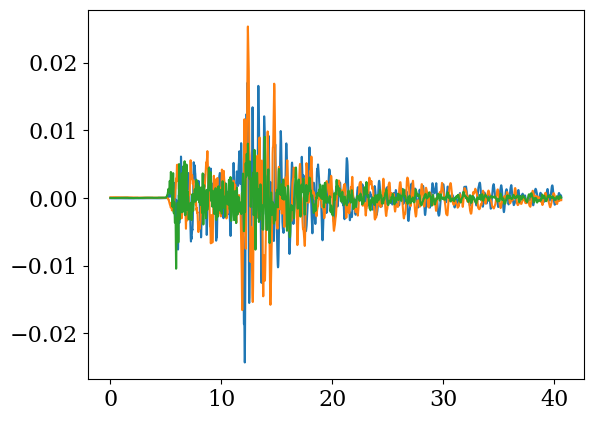

In [54]:
idx = 237 # 237, 1524 , 1822
print(str(dataset_observed.hypocentral_distance[idx]*1e3)+','+str(dataset_observed.hypocentre_depth[idx])+','+str(dataset_observed.magnitude[idx])+','+str(dataset_observed.vs30s[idx])+','+str(dataset_observed.azimuthal_gap[idx])+','+str(6))
print(np.where((dataset_observed.hypocentral_distance*1e3==47.7885788840879) * (dataset_observed.hypocentre_depth==42.9) * (dataset_observed.magnitude==5.161739493073708) * (dataset_observed.vs30s==173.69727047146395) * (dataset_observed.azimuthal_gap==11.183357303531436)) )
# print(str(dataset_generated.hypocentral_distance[idx])+','+str(dataset_generated.hypocentre_depth[idx])+','+str(dataset_generated.magnitude[idx])+','+str(dataset_generated.vs30s[idx])+','+str(dataset_generated.azimuthal_gap[idx])+','+str(6))
fig = plt.figure()
ax = fig.gca()
ax.plot(time, dataset_observed.waveforms[idx, 0, :4064])
ax.plot(time, dataset_observed.waveforms[idx, 1, :4064])
ax.plot(time, dataset_observed.waveforms[idx, 2, :4064])
plt.show()

In [46]:
def plot_seismic_comparison(observed_data, generated_data, dt=0.01, 
                           magnitudes=None, distances=None, vsc_values=None,
                           output_file='seismic_waveforms_comparison.png'):
    """
    Create comparison plots between observed and generated seismic waveforms.
    Each waveform is normalized by its own maximum amplitude, with max values displayed at t ≈ 35s.
    
    Parameters:
        observed_data: numpy array of shape [3, 3, 4064] - observed waveforms
        generated_data: numpy array of shape [30, 3, 4064] - generated waveforms
        dt: time step in seconds
        magnitudes: list of magnitudes for each row
        distances: list of distances for each row
        vsc_values: list of velocity values for each row
        output_file: filename to save the plot
    """
    # Default values if not provided
    if magnitudes is None:
        magnitudes = [5.613218662517143, 5.447894404357664, 5.161739493073708]
    if distances is None:
        distances = [44.58, 43.91, 47.78]
    if vsc_values is None:
        vsc_values = [310.67, 966.76, 173.69]

    azi_gap = [48.70, 93.01, 11.18]
    depth = [36.0, 34.9, 42.9]
    
    # Verify input shapes
    assert observed_data.shape[0] == 3, "Expected 3 events in observed data"
    assert observed_data.shape[1] == 3, "Expected 3 components in observed data"
    assert generated_data.shape[0] == 30, "Expected 30 waveforms in generated data"
    assert generated_data.shape[1] == 3, "Expected 3 components in generated data"
    
    # Create time array
    n_samples = observed_data.shape[2]
    time = np.arange(0, n_samples * dt, dt)
    
    # Component labels
    components = ["Radial", "Transverse", "UD"]
    
    # Setup figure and grid
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 3, figure=fig, wspace=0.15, hspace=0.1)
    
    # Number of waveforms to plot in each subplot (1 observed + n generated)
    n_traces_per_row = 6
    n_generated_per_row = n_traces_per_row - 1  # Save one spot for observed
    
    # Back to original approach: individual normalization by each waveform's own maximum
    
    # Calculate which generated waveforms to include for each event
    # We have 10 generated per observed, but want to show fewer
    selected_indices = []
    for i in range(3):  # For each event
        start_idx = i * 10
        # Select indices evenly spaced from the 10 available
        step = 10 // n_generated_per_row
        selected = [start_idx + j*step for j in range(n_generated_per_row)]
        selected_indices.append(selected)
    
    # Separation between traces in the plot
    separation = 1.0
    
    # For each row (event)
    for row in range(3):
        magnitude = magnitudes[row]
        distance = distances[row]
        
        # For each column (component)
        for col in range(3):
            ax = fig.add_subplot(gs[row, col])
            
            # First plot the selected generated waveforms
            for i, idx in enumerate(selected_indices[row]):
                waveform = generated_data[idx, col, :]
                
                # Get original maximum amplitude for annotation
                original_max = np.max(np.abs(waveform))
                
                # Normalize waveform by its own maximum amplitude
                if original_max > 1e-10:
                    normalized_waveform = waveform / original_max * 0.4
                else:
                    normalized_waveform = waveform
                
                # Calculate vertical position (start from top)
                vertical_pos = (n_traces_per_row - 1 - i) * separation
                
                # Determine color (alternating dark and light red)
                if i % 2 == 0:
                    color = '#8B0000'  # Dark red
                else:
                    color = '#FF6666'  # Light red
                
                # Plot the waveform
                ax.plot(time[:4000], normalized_waveform[:4000] + vertical_pos, 
                       color=color, linewidth=0.8)
                
                # Add maximum amplitude annotation at t ≈ 35s
                if original_max > 1e-10:
                    ax.text(35, vertical_pos + 0.1, f'{original_max:.2e}', 
                           fontsize=8, color=color, ha='center', va='bottom')
            
            # Now plot the observed waveform (bottom trace)
            observed_waveform = observed_data[row, col, :]
            
            # Get original maximum amplitude for annotation
            obs_original_max = np.max(np.abs(observed_waveform))
            
            # Normalize observed waveform by its own maximum amplitude
            if obs_original_max > 1e-10:
                normalized_observed = observed_waveform / obs_original_max * 0.4
            else:
                normalized_observed = observed_waveform
            
            # Plot at the bottom position
            ax.plot(time[:4000], normalized_observed[:4000], 
                   color='black', linewidth=0.8)
            
            # Add maximum amplitude annotation for observed waveform at t ≈ 35s
            if obs_original_max > 1e-10:
                ax.text(35, 0.1, f'{obs_original_max:.2e}', 
                       fontsize=8, color='black', ha='center', va='bottom', weight='bold')
            
            # Set x-axis limits
            ax.set_xlim(0, 40)  # Show first 40 seconds
            
            # Hide x labels for all but bottom row
            if row < 2:
                ax.set_xticklabels([])
            
            # Add component title for top row
            if row == 0:
                ax.set_title(components[col], fontsize=16)
            
            # Add x-axis label for bottom row
            if row == 2:
                ax.set_xlabel("Time [s]", fontsize=12)
            
            # Remove y ticks and labels
            ax.set_yticks([])
            ax.set_ylabel("")
            
            # Add dotted reference lines
            for t in [10, 20, 30]:
                ax.axvline(x=t, color='black', linestyle=':', alpha=0.3)
            
            # Remove unnecessary spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            
            # Add magnitude and distance labels to left column
            if col == 0:
                # Create text for magnitude and distance
                label_text = f"M {magnitude:.1f}, Vs30: {vsc_values[row]} m/s\nDistance: {distance:.1f} km, Depth: {depth[row]} km, \nAzimuthal Gap: {azi_gap[row]}$^\circ$"
                
                # Add the text to the left of the plot
                trans = transforms.blended_transform_factory(
                    fig.transFigure, ax.transData)
                ax.text(-0.01, (n_traces_per_row-1) * separation / 2, label_text,
                        ha='right', va='center', transform=trans, fontsize=10)
    
    # Add "Acceleration [m/s²]" label on the right side
    for row in range(3):
        ax = fig.axes[row*3 + 2]  # Right column for each row
        ax.text(1.05, 0.5, "Acceleration [m/s²]", 
                rotation=90, ha='left', va='center', 
                transform=ax.transAxes, fontsize=12)
    
    # Apply tight layout and save
    plt.tight_layout()
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(os.path.abspath(output_file)) if os.path.dirname(output_file) else '.', 
                exist_ok=True)
    
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")
    
    return fig

<>:156: SyntaxWarning: invalid escape sequence '\c'
<>:156: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_226345/4245720761.py:156: SyntaxWarning: invalid escape sequence '\c'
  label_text = f"M {magnitude:.1f}, Vs30: {vsc_values[row]} m/s\nDistance: {distance:.1f} km, Depth: {depth[row]} km, \nAzimuthal Gap: {azi_gap[row]}$^\circ$"


/tmp/ipykernel_226345/4245720761.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved to: figures/updated/seismic_waveforms_comparison2.svg


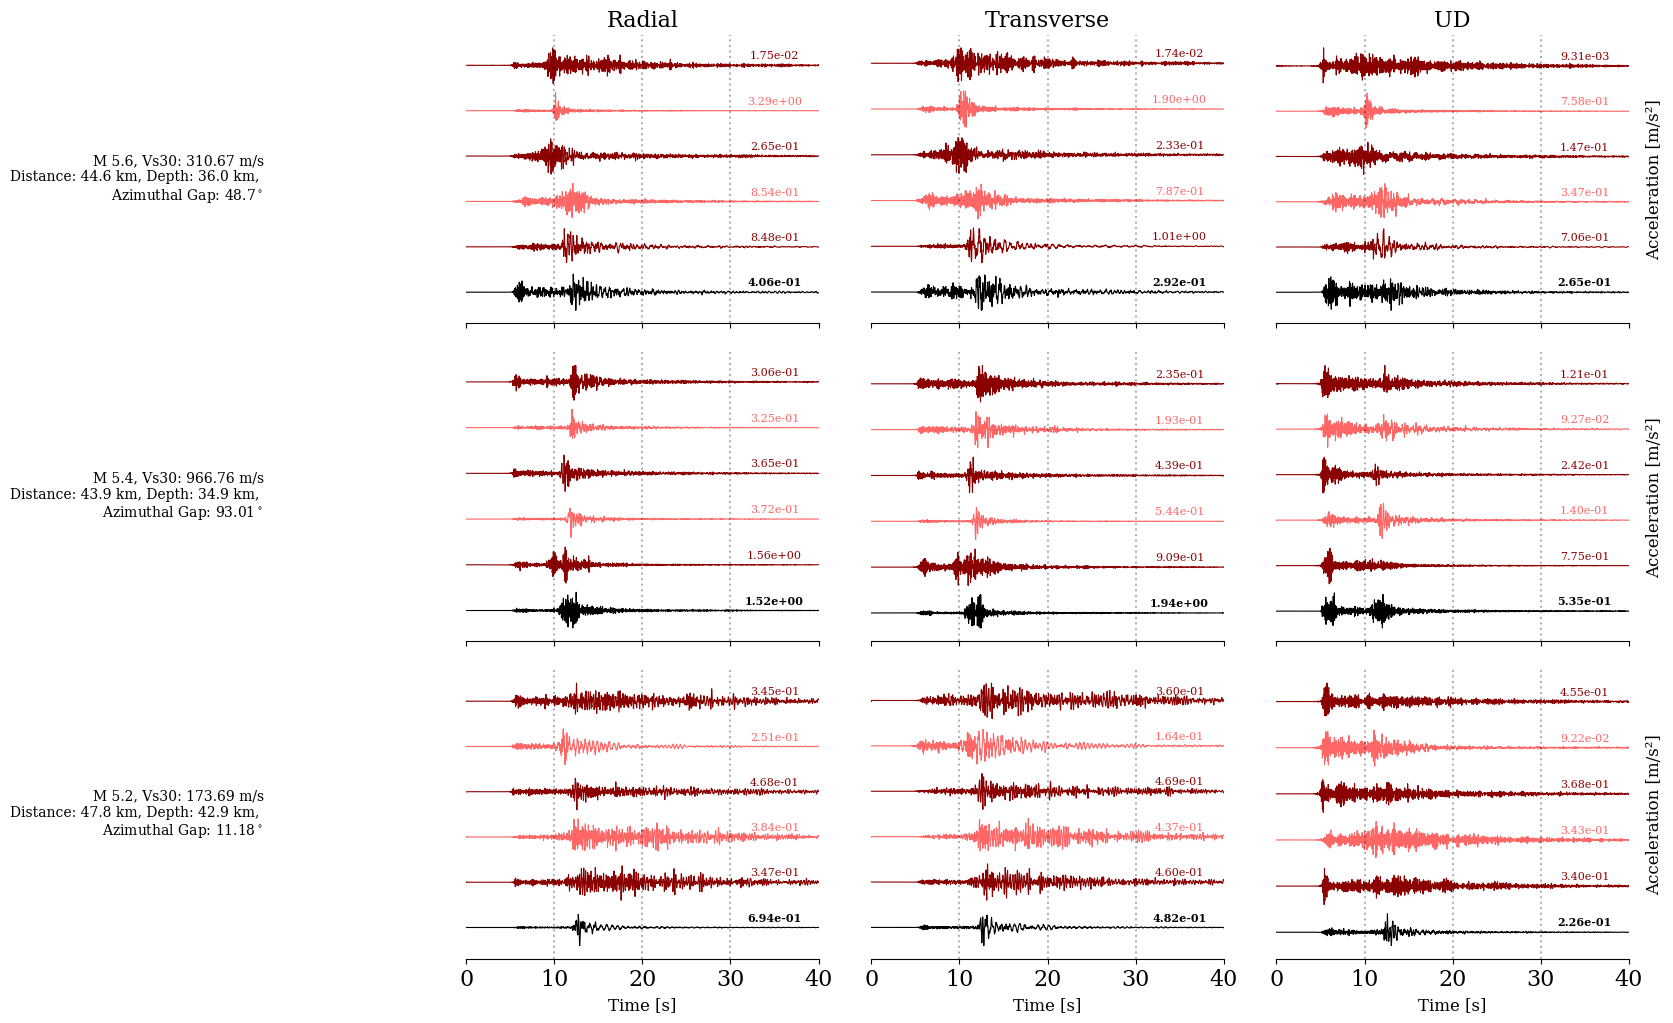

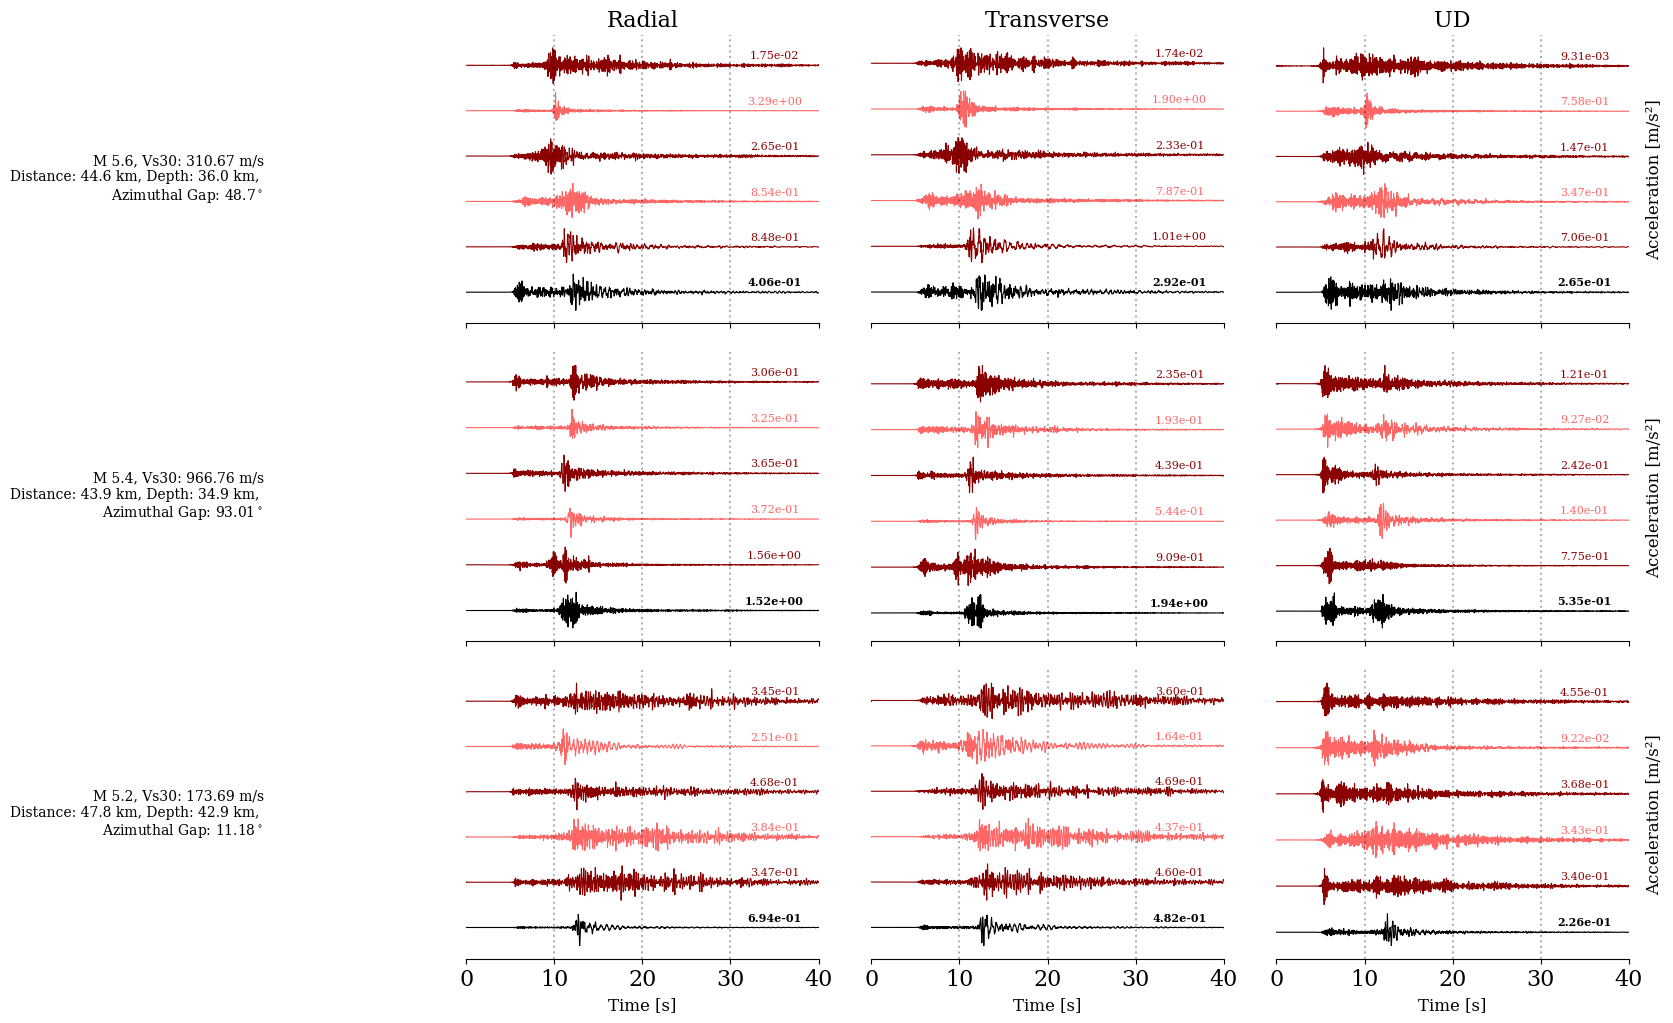

In [ ]:
observed_data = dataset_observed.waveforms[[237, 1524 , 1822],:,:4064]
plot_seismic_comparison(observed_data, dataset_generated.waveforms, dt=0.01, 
                           magnitudes=None, distances=None, vsc_values=None,
                           output_file='figures/updated/seismic_waveforms_comparison2.svg')

In [37]:
observed_data.shape

(3, 3, 4064)